In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

In [3]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
convolver = nsx.Convolver()
convolver.setKernel(kernel.matrix())

finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationScale(3.0)
finder.setBackgroundScale(5.0)
finder.setSearchScale(1.0)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

peaks = finder.find([data])
print(len(peaks))

9200


In [4]:
for peak in peaks:
    peak.setSelected(True)

In [5]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1000.0:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))

8144


In [6]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 8144 peaks
indexed 3833 of 8144
found unit cell with parameters: 
a:  54.37636516462557
b:  58.50673662794026
c:  67.37399546643454
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948968


In [7]:
lower = np.array([-1.0, -1.0, -1.0])
upper = np.array([1.0, 1.0, 1.0])

peak_list = nsx.PeakList()
for p in good_peaks:
    peak_list.push_back(p)

si = nsx.ShapeIntegrator(nsx.AABB(lower, upper), 10, 10, 10)
si.integrate(peak_list, data, 4.0, 4.5, 6.0)

In [8]:
lib = si.library()
help(lib)

Help on ShapeLibrary in module pynsx object:

class ShapeLibrary(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_ShapeLibrary(...)
 |  
 |  addPeak(self, peak, profile, integrated_profile)
 |  
 |  findNeighbors(self, ev, radius, nframes)
 |  
 |  meanCovariance(self, reference_peak, radius, nframes)
 |  
 |  meanIntegratedProfile(self, ev, radius, nframes)
 |  
 |  meanPearson(self)
 |  
 |  meanProfile(self, ev, radius, nframes)
 |  
 |  predictCovariance(self, *args)
 |  
 |  updateFit(self, num_iterations)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__

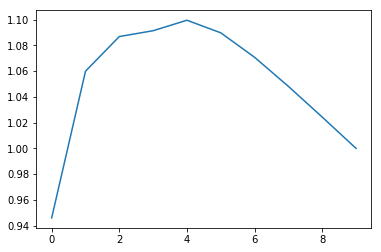

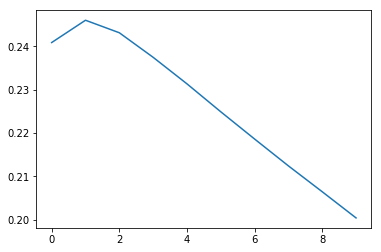

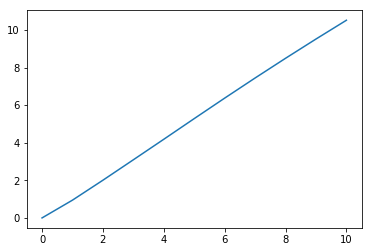

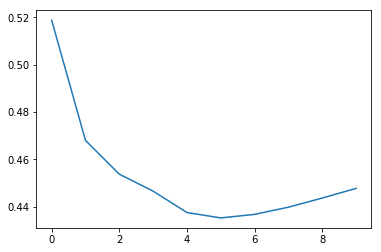

In [9]:
prof = lib.meanIntegratedProfile(nsx.DetectorEvent(1050, 450, 50), 2000, 100)
bins = prof.bins()

vals = np.array([ b.value() for b in bins ])
sigs = np.array([ b.sigma() for b in bins ])


plt.plot(vals)
plt.show()

plt.plot(sigs)
plt.show()

cm = [ 0.0 for v in vals ]

for i in range(len(vals)):
    for j in range(i, len(vals)):
        cm[j] += vals[i]
        
cm = [0.0] + cm
plt.plot(cm)
plt.show()

plt.plot(np.sqrt(sigs)/vals)
plt.show()

In [10]:
class GaussianIntegrator(nsx.IPeakIntegrator):
    def __init__(self):
        nsx.IPeakIntegrator.__init__(self)
        self.data = []
        
    def compute(self, peak, region):
        #s = nsx.StrongPeakIntegrator()
        #s.compute(peak, region)
        #self._integratedIntensity = s._integratedIntensity
        #self._meanBackground = s._meanBackground
        self.data.append((peak, nsx.PeakData(region.peakData())))
        return True
    
peak_list = nsx.PeakList()

for p in good_peaks:
    peak_list.push_back(p)
        
g = GaussianIntegrator()
g.integrate(peak_list, data, 3.0, 4.0, 6.0)
print("done")

SystemError: <built-in function IPeakIntegrator_integrate> returned a result with an error set

In [ ]:
help(nsx.ShapeIntegrator)